# SVM Classifier: Preprocess ONLY Training Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re


In [2]:
# Safe download for necessary NLTK resources
resources = {
    'punkt': 'tokenizers/punkt',
    'stopwords': 'corpora/stopwords',
    'wordnet': 'corpora/wordnet',
    'omw-1.4': 'corpora/omw-1.4',
    'averaged_perceptron_tagger': 'taggers/averaged_perceptron_tagger'
}

for resource, path in resources.items():
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(resource)


[nltk_data] Downloading package wordnet to /Users/finko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/finko/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# Load dataset
df = pd.read_csv("/Users/finko/Desktop/Ironhack/nlp-project/dataset/data.csv")
print("Dataset loaded. Shape:", df.shape)
print(df.head())

Dataset loaded. Shape: (39942, 5)
   label                                              title  \
0      1  As U.S. budget fight looms, Republicans flip t...   
1      1  U.S. military to accept transgender recruits o...   
2      1  Senior U.S. Republican senator: 'Let Mr. Muell...   
3      1  FBI Russia probe helped by Australian diplomat...   
4      1  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   


In [4]:
# Step 1: Split raw data (before any preprocessing)
X = df['text'].astype(str)
y = df['label']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print("Data split complete. Train size:", len(X_train_text), "Test size:", len(X_test_text))

Data split complete. Train size: 31953 Test size: 7989


In [5]:
# Step 2: Preprocess ONLY the training text
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = word_tokenize(text.lower())
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

X_train_clean = X_train_text.apply(clean_text)
print("Training text preprocessed.")

Training text preprocessed.


In [6]:
# Step 3: TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(X_train_clean)
X_test = vectorizer.transform(X_test_text)  # UNPROCESSED test data

print("TF-IDF vectorized. Train shape:", X_train.shape, "Test shape:", X_test.shape)

TF-IDF vectorized. Train shape: (31953, 1000) Test shape: (7989, 1000)


In [7]:
# Step 4: Train the SVM model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
print("SVM model trained.")

SVM model trained.


Evaluation Results:
Accuracy: 0.9051195393666291

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91      3996
           1       0.98      0.83      0.90      3993

    accuracy                           0.91      7989
   macro avg       0.92      0.91      0.90      7989
weighted avg       0.92      0.91      0.90      7989



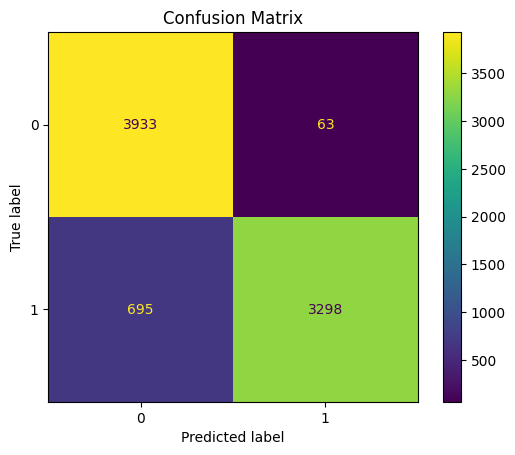

In [8]:
# Step 5: Evaluate
y_pred = svm_model.predict(X_test)

print("Evaluation Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()

In [11]:
from sklearn.model_selection import ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve_for_embeddings(estimator, title, X_raw, y, embedding_func, cv, n_jobs=1,
                                       train_sizes=np.linspace(0.1, 0.9, 5)):
    """
    Plot learning curve using embedded features built from raw tokenized data.
    """
    train_scores = []
    test_scores = []

    for frac in train_sizes:
        X_frac, _, y_frac, _ = train_test_split(X_raw, y, train_size=frac, random_state=42)

        # Transform using embedding_func
        X_emb = np.array([embedding_func(doc, w2v_model, idf_weights) for doc in X_frac])

        # Manual CV
        inner_cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
        frac_train_scores = []
        frac_test_scores = []

        for train_idx, val_idx in inner_cv.split(X_emb):
            X_train_cv, X_val_cv = X_emb[train_idx], X_emb[val_idx]
            y_train_cv, y_val_cv = y_frac.iloc[train_idx], y_frac.iloc[val_idx]

            estimator.fit(X_train_cv, y_train_cv)
            frac_train_scores.append(estimator.score(X_train_cv, y_train_cv))
            frac_test_scores.append(estimator.score(X_val_cv, y_val_cv))

        train_scores.append(np.mean(frac_train_scores))
        test_scores.append(np.mean(frac_test_scores))

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores, 'o-', label='Training Score')
    plt.plot(train_sizes, test_scores, 'o-', label='Cross-validation Score')
    plt.xlabel("Training Set Fraction")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()

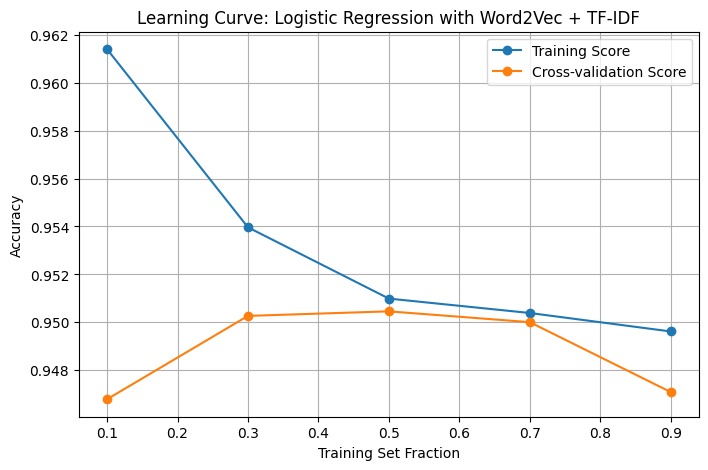

In [12]:
from sklearn.linear_model import LogisticRegression

from gensim.models import Word2Vec

# Define the get_weighted_embedding function
def get_weighted_embedding(doc, w2v_model, idf_weights):
    """
    Compute the weighted Word2Vec embedding for a document.
    """
    words = doc.split()
    embedding = np.zeros(w2v_model.vector_size)
    weight_sum = 0

    for word in words:
        if word in w2v_model.wv and word in idf_weights:
            weight = idf_weights[word]
            embedding += w2v_model.wv[word] * weight
            weight_sum += weight

    if weight_sum != 0:
        embedding /= weight_sum

    return embedding

# Example Word2Vec model and IDF weights (replace with your actual model and weights)
w2v_model = Word2Vec(sentences=X_train_clean.apply(str.split), vector_size=100, window=5, min_count=1, workers=4)
idf_weights = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))

# Plot the learning curve
plot_learning_curve_for_embeddings(
    estimator=LogisticRegression(max_iter=1000),
    title="Learning Curve: Logistic Regression with Word2Vec + TF-IDF",
    X_raw=X_train_clean,
    y=y_train,
    embedding_func=lambda doc, w2v_model=w2v_model, idf_weights=idf_weights: get_weighted_embedding(doc, w2v_model, idf_weights),
    cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=42),
    n_jobs=-1
)